# **Classification and Detection of Disaster Tweets**
---

Natural Disasters have caused an average of 60,000 deaths worldwide. When Natural Disaster strike, many that have witnessed it would often report it on social media in real time which can be done through twitter or facebook. Many often seek news from social media as it is much faster than traditional media. Since people would report it on social media, there is a need for fast response from the rescue operators to respond to the disaster. However, there is currently no system in place to alert the rescue operators about a disaster that is posted on social media.

The goal of this project is to identify tweets that are deemed as a `Disaster Tweet` through the use of Machine Learning

In order to achieve the goals set out, we will need to:
* Find a suitable dataset
* Clean the dataset
* Find a suitable model for training
* Implement the idea

## Prerequisite
---

### Import Libraries for project
---

Before we begin, we will import the following libraries:
> `numpy` - Array for data manipulation  
> `pandas` - Data manipulation for source  
> `seaborn`, `mathplotlib` -  Data visualization library  
> `wordcloud` -  Wordcloud visualization  
> `sklearn` -  Used to split train and test data  
> `tensorflow` - Machine Learning library  
> `re` -  Regular expression for cleaning data  
> `string` - Finding out all punctuations for cleaning data  

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
import re
import string
import nltk
from nltk.tokenize import RegexpTokenizer
import collections

### Import Dataset from CSV File
---

Dataset by [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data).  
Since it is formatted into a CSV file, we can import the dataset into Python through `read_csv()` function.  
`head()` function is used to verify that the dataset is successfully imported.

In [ ]:
fileURL = "https://raw.githubusercontent.com/woonyee28/mini-project/main/data/train.csv" #Assign link of dataset to variable
original_tweets = pd.read_csv(fileURL) #Import data into original_tweets

In [ ]:
#original_tweets = pd.read_csv("/content/Dataset/mini_project_train.csv") #Import data from CSV File
original_tweets.head() #Verify that data is imported

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Count number of dataset for each category
---

The dataset `original_tweets` has a column named `target` that stores values `0`, and `1`.

The value represents whether data in the row is classified as Disaster Text, where `1` represents **Disaster Text**, and `0` represents **Non-Disaster Text**.

We will change the column name to `isDisaster` to make it clearer, then count the number of dataset in each category of `isDisaster`

In [ ]:
original_tweets.rename(columns={'target': 'isDisaster'},inplace=True) #Rename the column 'label' to 'isDisaster'
original_tweets.groupby('isDisaster').count() #Group based on the category, and count the number of entries for each category

,id,keyword,location,text
isDisaster,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


Number of tweets classified as **Disaster Speech**: **3,271**  
Number of tweets classified as **Non-Disaster Speech**: **4,342**  

The dataset has a disproportionate number of Disaster Speech to Non-Disaster Speech. We will need to balance the dataset. We will be doing that in the **Imbalanced Dataset** section

## Data Cleaning
---

The data we chose contains special characters which would not work with tensorflow. We will need to clean up all unnecessary characters before continuing. 

### Data Cleaning Functions
---

To use the data, we will need to clean up any unnecessary characters that may cause issues:
> `remove_user()` - Removes `@user` found in tweets. Removing the `@user` would increase the accuracy of the result. Else, it will show up in the wordcould for both Disaster Text and Non-Disaster Text.  
> `remove_URL()` - Removes URLs found in tweets.   
> `remove_HTML()` - Removes HTML tags if any.  
> `replace_HTML_reserve()` - Replaces HTML reserve characters such as `&lt;`, `&gt;`, `&amp;` into its original form `<`, `>`, `&`.  
> `remove_emoji()` - Removes any emojis in tweets.  
> `decontraction()` - Replaces contractions like `let's` into its orignal form `let us`.    
> `remove_non_alphanumspace()` - Removes weird charactesr such as `Â` and `ð`, any punctuations, and special characters.  
> `seperate_alphanumeric()` - Separates words like `gr8` into `gr 8` for data processing later on.  
> `cont_rep_char()` - Replaces 3 or more repeated character without any space to 2 repeated character. e.g., `eee` to `ee`  
> `unique_char()` - Find repeated characters and pass it to `cont_rep_char()` function, then replaces the said character.  
> `remove_all()` - Takes in parameters `(dataset, column)` and execute the above functions on the given column in the dataset.

In [ ]:
def remove_user(text):
    user = re.compile(r'@user')
    return user.sub(r'', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'', text)

def replace_HTML_reserve(text):
    text = re.sub(r"&amp;", "&", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&le;", "<=", text)
    text = re.sub(r"&ge;", ">=", text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"(\S)\'re", r"\1 are", text)
    text = re.sub(r"(\S)\'s", r"\1 is", text)
    text = re.sub(r"(\S)\'d", r"\1 would", text)
    text = re.sub(r"(\S)\'d've", r"\1 would have", text)
    text = re.sub(r"(\S)\'ll", r"\1 will", text)
    text = re.sub(r"(\S)\'ll've", r"\1 will have", text)
    text = re.sub(r"(\S)\'t", r"\1 not", text)
    text = re.sub(r"(\S)\'ve", r"\1 have", text)
    text = re.sub(r"(\S)\'m", r"\1 am", text)
    text = re.sub(r"(\S)\'re", r"\1 are", text)
    return text 
    
"""
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
"""

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'([A-Za-z])\1+', rep, text)
    return substitute

def remove_non_alphanumspace(text):
    url = re.compile(r'[^0-9a-zA-Z\s]+')
    return url.sub(r'', text)

def remove_all(dataset, column):
    dataset[column] = dataset[column].apply(lambda x : remove_user(x))
    dataset[column] = dataset[column].apply(lambda x : remove_URL(x))
    dataset[column] = dataset[column].apply(lambda x : remove_HTML(x))
    dataset[column] = dataset[column].apply(lambda x : replace_HTML_reserve(x))
    dataset[column] = dataset[column].apply(lambda x: remove_emoji(x))
    dataset[column] = dataset[column].apply(lambda x : decontraction(x))
    dataset[column] = dataset[column].apply(lambda x : remove_non_alphanumspace(x))
    dataset[column] = dataset[column].apply(lambda x : seperate_alphanumeric(x))
    dataset[column] = dataset[column].apply(lambda x : unique_char(cont_rep_char, x))

### Cleaning the data
---

Once we construct the different functions to clean our data, we can start cleaning our dataset and verify it.

In [ ]:
remove_all(original_tweets, 'text'); #removes all unnecessary characters from [dataset, column]
original_tweets.drop(['keyword', 'location'], axis=1, inplace=True) #Removes unnecessary rows from the dataset
original_tweets.head(10) #Verify that all unnecessary characters have been removed from the dataset

,id,text,isDisaster
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
5,8,RockyFire Update California Hwy 20 closed in b...,1
6,10,flood disaster Heavy rain causes flash floodin...,1
7,13,I am on top of the hill and I can see a fire i...,1
8,14,There is an emergency evacuation happening now...,1
9,15,I am afraid that the tornado is coming to our ...,1


### Filtering Disaster Text vs Non-Disaster Text
---

We will filter out disaster text and non-disaster text by the value of column `isDisaster`. We will store them into `isDisaster_tweets` and `isNotDisaster_tweets` respectively.

In [ ]:
isDisaster_tweets = original_tweets[original_tweets.isDisaster == 1] #Filters out all disaster texts and stores it into isDisaster_tweets
isNotDisaster_tweets = original_tweets[original_tweets.isDisaster == 0] #Filters out all non-disaster text and stores it into isNotDisaster_tweets

#### Verify filter

In [ ]:
isDisaster_tweets.head(10)

,id,text,isDisaster
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
5,8,RockyFire Update California Hwy 20 closed in b...,1
6,10,flood disaster Heavy rain causes flash floodin...,1
7,13,I am on top of the hill and I can see a fire i...,1
8,14,There is an emergency evacuation happening now...,1
9,15,I am afraid that the tornado is coming to our ...,1


In [ ]:
isNotDisaster_tweets.head(10)

,id,text,isDisaster
15,23,What is up man,0
16,24,I love fruits,0
17,25,Summer is lovely,0
18,26,My car is so fast,0
19,28,What a gooaal,0
20,31,this is ridiculous,0
21,32,London is cool,0
22,33,Love skiing,0
23,34,What a wonderful day,0
24,36,LOOL,0


## Imbalanced Dataset
---

Previously, we have identified that there is a disproportionate number of Disaster Text to Non-Disaster Text. We will be doing data balancing here.

### Finding percentage of Disaster Text and Non-Disaster Text
---

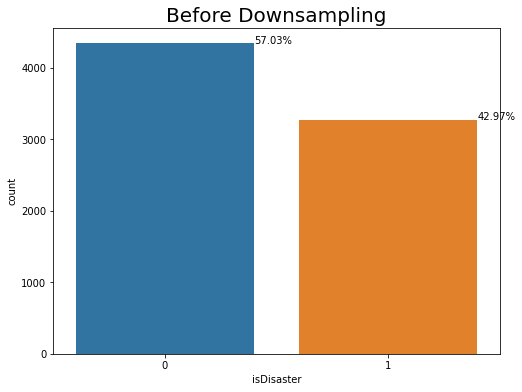

(4342, 3) (3271, 3)


In [ ]:
plt.figure(figsize = (8,6))
cntPlot = sns.countplot(x = 'isDisaster', data = original_tweets)
plt.title('Before Downsampling', fontsize=20)
for p in cntPlot.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(isNotDisaster_tweets)+len(isDisaster_tweets)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    cntPlot.annotate(percentage, (x, y))
plt.show()

print(isNotDisaster_tweets.shape, isDisaster_tweets.shape)

From the graph, we can see that the percentage is far from the ideal `50%`. The number of data in each category is also imbalanced (**4,342** vs **3,271**). We will need to downsample `isDisaster = 0` to produce a balanced  training dataset.

### Downsample Data
---

Using `sample()` function, we can downsample `isDisaster = 0` to match the number of data in `isDisaster = 1`

NOTE: comment out this line if accuracy high for original data

In [ ]:
isNotDisaster_tweets = isNotDisaster_tweets.sample(n = len(isDisaster_tweets))

### Verify downsampling
---


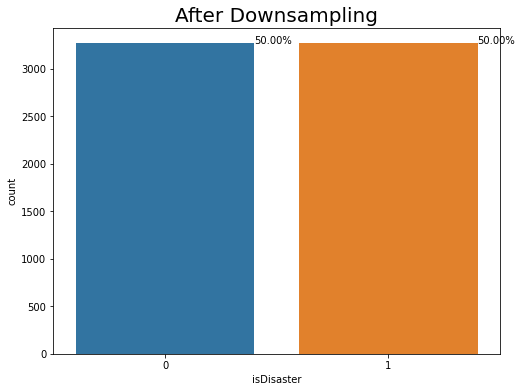

(3271, 3) (3271, 3)


In [ ]:
tweets_concat = pd.concat([isNotDisaster_tweets,isDisaster_tweets]).reset_index(drop=True)
plt.figure(figsize=(8,6))
plt.title('After Downsampling', fontsize=20)
cntPlot = sns.countplot(x=tweets_concat.isDisaster)
for p in cntPlot.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(isNotDisaster_tweets)+len(isDisaster_tweets)))
    x = p.get_x() + (p.get_width())
    y = p.get_height()
    cntPlot.annotate(percentage, (x, y))
plt.show()

print(isNotDisaster_tweets.shape, isDisaster_tweets.shape)

Now we have successfully balanced out the percentage to `50%` and it has matching number of data (**3,271**). We can proceed to visualize the data.

## Data Visualization
---

### Preparation for Wordcloud
---

To prepare the data for the visualization, we will need to store tweets into a numpy array.

In [ ]:
isDisaster_tweets_numpy = " ".join(isDisaster_tweets.text.to_numpy().tolist())
isNotDisaster_tweets_numpy = " ".join(isNotDisaster_tweets.text.to_numpy().tolist())

### Wordcloud!
---

We can generate wordcoulds for both `isDisaster_tweets` and `isNotDisaster_tweets` to visualize the data. From the visualization, we can observe most common keywords that were used in tweets classified in their own category.

#### Wordcloud for **isDisaster_tweets**
---

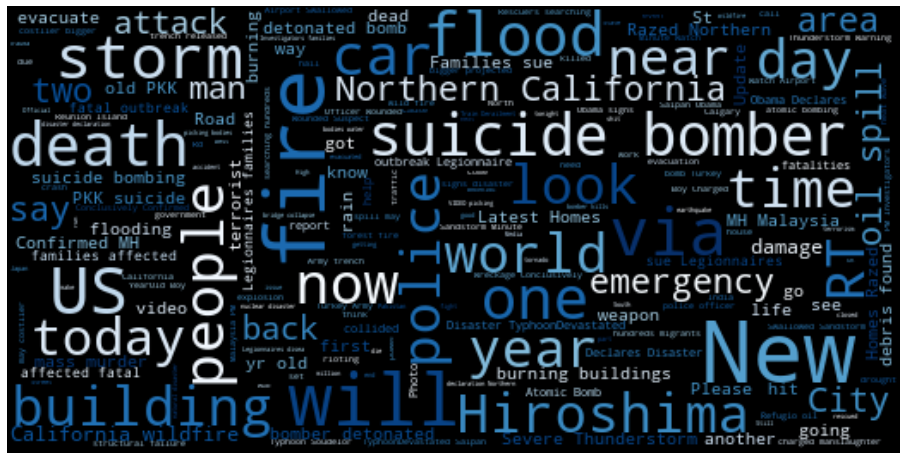

In [ ]:
isDisaster_tweets_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(isDisaster_tweets_numpy)
plt.figure(figsize=(16,10)) #Size of figure
plt.imshow(isDisaster_tweets_wordcloud, interpolation='bilinear') #Create an wordcloud image, bilinear to smooth edges
plt.axis('off') #Turn off axis
plt.show() #Displays the wordcloud

#### Wordcloud for **isNotDisaster_tweets**
---

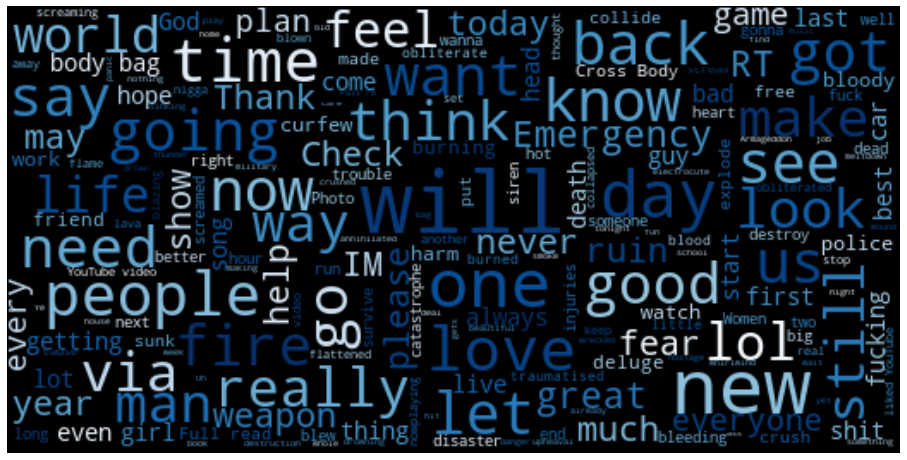

In [ ]:
isNotDisaster_tweets_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(isNotDisaster_tweets_numpy)
plt.figure(figsize=(16,10)) #Size of figure
plt.imshow(isNotDisaster_tweets_wordcloud, interpolation='bilinear') #Create an wordcloud image, bilinear to smooth edges
plt.axis('off') #Turn off axis
plt.show() #Displays the wordcloud

### Other Data Visualization
---

By using other Data Visualization tools (mainly Histograms), we are able to:
*   Compare the `length` of tweeets for both categories
*   `Count of the most common words` in the tweeets for both categories



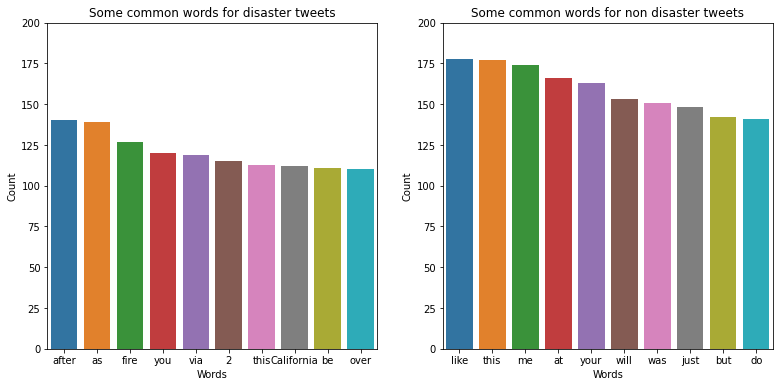

In [ ]:
def get_wrd_count(text_lst):
    """Get Word Counters for EDA"""
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter
    
#Common words for each category

isDisaster_wrd = get_wrd_count(isDisaster_tweets['text'].tolist())
isNotDisaster_wrd = get_wrd_count(isNotDisaster_tweets['text'].tolist())

isDisaster_wrd_cnt_sorted_32 = isDisaster_wrd.most_common(n=32) 
isDisaster_wrd_cnt_sorted_22 = isDisaster_wrd.most_common(n=22) 
isDisaster_wrd_cnt_sorted = [item for item in isDisaster_wrd_cnt_sorted_32 if item not in isDisaster_wrd_cnt_sorted_22]
isNotDisaster_wrd_cnt_sorted_32 = isNotDisaster_wrd.most_common(n=32) 
isNotDisaster_wrd_cnt_sorted_22 = isNotDisaster_wrd.most_common(n=22) 
isNotDisaster_wrd_cnt_sorted = [item for item in isNotDisaster_wrd_cnt_sorted_32 if item not in isNotDisaster_wrd_cnt_sorted_22]
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in isDisaster_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in isNotDisaster_wrd_cnt_sorted]
#print(l1, h1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0]);
ax[0].set_ylim(top=200);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Some common words for disaster tweets");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1]);
ax[1].set_ylim(top=200);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Some common words for non disaster tweets");

From this histogram, we are able to obtain the count of words that most commonly appear in both the categories. This is very similar to the wordcloud, but we can obtain a numerical value of the words in this histogram.

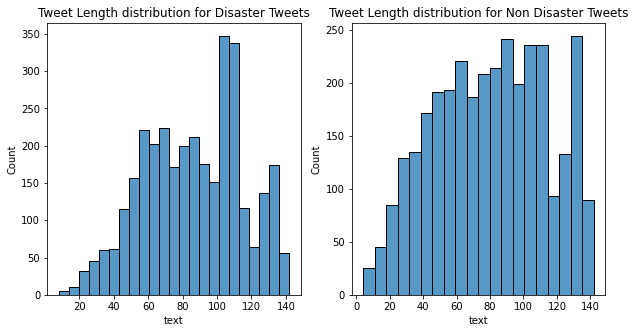

In [ ]:
isDisaster_tweets_len = isDisaster_tweets['text'].apply(lambda x:len(x) )
isNotDisaster_tweets_len = isNotDisaster_tweets['text'].apply(lambda x:len(x) )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(isDisaster_tweets_len, ax=ax[0]);
ax[0].set_title("Tweet Length distribution for Disaster Tweets");
sns.histplot(isNotDisaster_tweets_len, ax=ax[1]);
ax[1].set_title("Tweet Length distribution for Non Disaster Tweets");
plt.show();

From this histogram, we are able to identify that disaster tweets have a huge spike around 100 to 110. Non-disaster tweets have a smoother peak at around 90 - 115. From this graph, we can use it to estimate the average length of tweet and use that information for the tokenization part.

## Data Pre-processing
---

### Splitting dataset into train and test dataset
---

We will split the dataset into `80%` train and `20%` test

In [ ]:
tweets_train, tweets_test, isDisaster_train, isDisaster_test = train_test_split(tweets_concat['text'], tweets_concat['isDisaster'], test_size=0.2)

### Text Processing
---

In this part, we will be utilizing TensorFlow to prepare data for deep learning models. We will be doing 3 procedures:
> `Tokenization` - The process of turning text into numbers. This is required as deep learning models does not understand text. Produces a dictionary of words and numbers.  
> `Sequencing` - The process of constructing text using numbers found in Tokenization. Produces sequence of numbers as a result.  
> `Padding` - The process of adding 0's to sequences. This is required as it needs to have inputs of same size.  

#### Preparation for Data Pre-processing
---

In this part, we will be setting up parameters for Tokenization, Sequencing, and Padding.

In [ ]:
tweets_concat['text_length'] = tweets_concat['text'].apply(len) #Create new column called text_length which stores the length of tweets
labels = tweets_concat.groupby('isDisaster').mean() #Gets the mean of text_length i.e., average length of tweet.

#Comparing and taking the higher average between isDisaster = 0 and isDisaster = 1
largest_mean_length = labels['text_length'][0] if labels['text_length'][0] > labels['text_length'][1] else labels['text_length'][1]
labels

,id,text_length
isDisaster,,
0,5284.844084,80.175482
1,5661.608071,86.292877


The parameters used here are as follows:
> `max_len` - Set the maximum length of tweet that we will be training with. `len(tweets) < max_len` will be padded, while `len(tweets) > max_len` will be truncated. We can use the average length as a gauge. By default, it will use the longest length of tweet. However, processing time will increase when training the model and effort may not drastically increase the accuracy.  
> `trunc_type` - `len(tweet) > max_len` will be truncated. Post means tweets will be truncated at the end of each sequence.  
> `padding_type` - `len(tweet) < max_len` will be padded. Post means tweets will be padded after each sequence.  
> `oov_token` - This will be used if there are no words matching the word list in the train dataset.  
> `number_of_tokens` - Set the maximum number of popular unique words we will be keeping. Processing time increases as this value increase. We will need to balance out to find the most optimal value.  

In [ ]:
max_len = 75 #round(largest_mean_length) 
trunc_type = "post" 
padding_type = "post" 
oov_token = "<OOV>" 
number_of_tokens = 1000

#### Tokenization
---

In [ ]:
tokenizer = Tokenizer(num_words = number_of_tokens, lower= 1, oov_token= oov_token) #Initializing Tokenizer
tokenizer.fit_on_texts(tweets_train) #Process of transforming words into numbers into a dictionary
word_index = tokenizer.word_index

##### Verify Tokenization
---

In [ ]:
print(word_index)

{'<OOV>': 1, 'the': 2, 'a': 3, 'in': 4, 'of': 5, 'to': 6, 'is': 7, 'i': 8, 'and': 9, 'for': 10, 'on': 11, 'you': 12, 'it': 13, 'not': 14, 'my': 15, 'that': 16, 'at': 17, 'are': 18, 'with': 19, 'by': 20, 'have': 21, 'this': 22, 'from': 23, 'was': 24, 'be': 25, 'as': 26, 'like': 27, 'but': 28, 'will': 29, 'up': 30, 'do': 31, 'am': 32, 'just': 33, 'me': 34, 'so': 35, 'we': 36, 'your': 37, 'has': 38, 'fire': 39, 'no': 40, 'after': 41, 'out': 42, 'an': 43, 'when': 44, '2': 45, 'all': 46, 'more': 47, 'if': 48, 'via': 49, 'can': 50, 'get': 51, 'they': 52, 'what': 53, 'now': 54, 'people': 55, 'he': 56, 'over': 57, 'been': 58, 'about': 59, 'news': 60, 'new': 61, 'us': 62, 'how': 63, 'there': 64, 'one': 65, 'would': 66, 'or': 67, 'who': 68, 'emergency': 69, 'disaster': 70, 'into': 71, 'police': 72, 'video': 73, '3': 74, 'than': 75, 'some': 76, '1': 77, 'her': 78, '4': 79, 'were': 80, 'suicide': 81, '5': 82, 'still': 83, 'crash': 84, 'day': 85, 'california': 86, 'burning': 87, 'his': 88, 'storm':

In [ ]:
print("Total Unique Tokens in tweets_train: {}".format(len(word_index)))

Total Unique Tokens in tweets_train: 13616


#### Sequencing
---

In this part, we will use the dictionary obtained from `Tokenizer` to map tweets to their respective keys.

In [ ]:
training_sequences = tokenizer.texts_to_sequences(tweets_train)
testing_sequences = tokenizer.texts_to_sequences(tweets_test)

##### Verify Sequencing
---

In [ ]:
print("Training Data:", training_sequences)
print("Testing Data:", testing_sequences)

Training Data: [[1, 7, 15, 719, 10, 667, 180, 1, 1], [33, 529, 94, 23, 1, 9, 1, 19, 3, 61, 565, 283, 668, 1, 669, 530, 14, 566, 567, 1, 1], [531, 239, 174, 828, 1, 1, 64, 7, 2, 284, 9, 361, 8, 1, 303, 1], [1, 15, 1, 7, 1, 1, 629, 21, 670, 6, 457, 3, 402, 120, 145], [1, 8, 150, 5, 16, 187, 93, 8, 107, 6, 2, 1, 1], [1, 403, 1, 1, 1, 18, 458, 2, 315, 52, 233, 91, 11, 39, 6, 316, 11, 91, 121, 11, 39], [1, 459, 8, 24, 14, 1, 1, 8, 130, 21, 304, 58, 4, 3, 225, 1, 747, 5, 2, 1, 8, 304, 593, 1], [1, 16, 168, 17, 34, 305, 8, 630, 9, 15, 143, 829, 18, 1, 34], [154, 1, 1], [1, 1, 1, 964, 1, 1, 1, 1, 1, 1, 1], [285, 5, 102, 70, 4, 1, 194, 29, 25, 1, 1, 1, 17, 436, 1, 1, 1, 1], [208, 7, 61, 269, 671, 720, 71, 787, 137, 460, 1, 830, 67, 404], [1, 1, 1, 40, 8, 32, 14, 8, 32, 1, 16, 52, 18, 1, 52, 50, 107, 148, 6, 110, 95, 14, 461, 4, 3, 97, 497], [52, 1, 1, 257, 71, 3, 135, 631, 1], [1, 226, 532, 1, 79, 1, 1, 831, 462, 20, 1, 62, 1, 45, 1, 1, 1, 20, 1], [828, 306, 4, 568, 76, 195, 6, 965, 594, 1, 533

#### Padding
---

In this part, we will use the sequences obtained from `Sequencing` to pad/truncate tweets. This is to ensure all are equal length.

In [ ]:
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

##### Verify Padding
---

In [ ]:
print("Training Data pad/truncate:", training_padded)
print("Testing Data pad/truncate:", testing_padded)

Training Data pad/truncate: [[  1   7  15 ...   0   0   0]
 [ 33 529  94 ...   0   0   0]
 [531 239 174 ...   0   0   0]
 ...
 [  8  21  58 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [139  22 485 ...   0   0   0]]
Testing Data pad/truncate: [[  1  72   1 ...   0   0   0]
 [735 460 136 ...   0   0   0]
 [  1   6   1 ...   0   0   0]
 ...
 [  2   1   1 ...   0   0   0]
 [765  63   8 ...   0   0   0]
 [ 22   1   1 ...   0   0   0]]


In [ ]:
print("Training Tensor\n"\
      "---------------\n"\
      "Rows: " + str(training_padded.shape[0]) + "\tColumns: " + str(training_padded.shape[1]) + "\n"\
      "Percentage: " + str(round((training_padded.shape[0]/(training_padded.shape[0]+testing_padded.shape[0]))*100)) + "%\n")

print("Testing Tensor\n"\
      "---------------\n"\
      "Rows: " + str(testing_padded.shape[0]) + "\tColumns: " + str(testing_padded.shape[1]) + "\n"\
      "Percentage: " + str(round((testing_padded.shape[0]/(training_padded.shape[0]+testing_padded.shape[0]))*100)) + "%\n")

Training Tensor
---------------
Rows: 5233	Columns: 75
Percentage: 80%

Testing Tensor
---------------
Rows: 1309	Columns: 75
Percentage: 20%



## Checkpoint \#01
---

At this point, we have:

*   Clean our data to remove any special characters and non-alphanumeric characters.
*   Balanced out our data to have 50% `isDisaster = 1` and `isDisaster = 0`
*   Visualise our data using various data visualization tools
*   Pre-process our data to prepare for deep learning
*   Dataset:  
> `training_padded` - Tweets for training  
> `testing_padded` - Tweets for testing  
> `isDisaster_train` - Category for tweet, training data  
> `isDisaster_test` - Category for tweet, testing data  


## Dense Network
---
Code below explains how we implemented the dense model architecture 

In [ ]:
vocab_size = 13000 #Defined earlier as number_of_tokens
embeding_dim = 16
drop_value = 0.2
n_dense = 24

Implementation of the dense model

*   The `sequential` calls for keras sequential model in which layers are added in a sequence
*   First layer: `Embedding layer` where it takes the integer-encoded vocabularly which was performed by tokenization function during the pre-processing of data which looks up the embedding vector for each word index
*   `GlobalAveragePooling layer` then returns a fixed length output vector for each example by averaging over the sequence dimension which allows the model to handle input of variable length in the simplest way and we have converted layer to 1 dimension
*   `Dense layer` with activation function `'relu'` 
*   `Dropouut layer` that prevents overfitting of data
*   `Dense layer` with `sigmoid` activation function that outputs the probabilities between 0 and 1 to classify our output




In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,embeding_dim,input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24,activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 75, 16)            208000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 25        
                                                                 
Total params: 208,433
Trainable params: 208,433
Non-trainable params: 0
________________________________________________

Compile and train the model using the `Adam optimizer` which is an efficient stochastic gradient descent because it automatically tunes itself and gives good results in a wide range of problems and the `BinaryCrossentropy loss` which is for binary classification problems

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Fitting of Model

The training process will run for a fixed number of iterations through the dataset which is called `Epochs`. 

`Epoch:` Number of times the learning algorithm will work through the entire training data set

`Callbacks: `callbacks is used to pass the early stopping parameter 

`EarlyStopping` (monitor='val_loss',patience=2) is used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(training_padded, isDisaster_train, epochs=num_epochs, validation_data=(testing_padded, isDisaster_test),callbacks=[early_stop],verbose=2)

Epoch 1/30
164/164 - 1s - loss: 0.6913 - accuracy: 0.5397 - val_loss: 0.6861 - val_accuracy: 0.6501 - 1s/epoch - 9ms/step
Epoch 2/30
164/164 - 1s - loss: 0.6696 - accuracy: 0.6721 - val_loss: 0.6393 - val_accuracy: 0.7456 - 792ms/epoch - 5ms/step
Epoch 3/30
164/164 - 1s - loss: 0.6007 - accuracy: 0.7348 - val_loss: 0.5496 - val_accuracy: 0.7792 - 651ms/epoch - 4ms/step
Epoch 4/30
164/164 - 1s - loss: 0.5304 - accuracy: 0.7562 - val_loss: 0.4971 - val_accuracy: 0.7594 - 696ms/epoch - 4ms/step
Epoch 5/30
164/164 - 1s - loss: 0.4881 - accuracy: 0.7802 - val_loss: 0.4622 - val_accuracy: 0.7769 - 687ms/epoch - 4ms/step
Epoch 6/30
164/164 - 1s - loss: 0.4560 - accuracy: 0.7971 - val_loss: 0.4450 - val_accuracy: 0.7937 - 665ms/epoch - 4ms/step
Epoch 7/30
164/164 - 1s - loss: 0.4389 - accuracy: 0.8049 - val_loss: 0.4344 - val_accuracy: 0.7914 - 682ms/epoch - 4ms/step
Epoch 8/30
164/164 - 1s - loss: 0.4246 - accuracy: 0.8148 - val_loss: 0.4329 - val_accuracy: 0.7983 - 671ms/epoch - 4ms/step
Epo

**Evaluate our Model**

After training our neural network using the dense model on the entire dataset, we can now evaluate the performance of the network on the same dataset. 

This will provide us the idea of how well we have modeled the dataset (e.g. train accuracy). 
By using the evaluate() function it will return a list with two values. The first value will be the loss of the model on the dataset while the second will be the accuracy of the model on the dataset. 

In [ ]:
loss, accuracy = model.evaluate(testing_padded,isDisaster_test)
print('Accuracy:', round((accuracy*100),2),'%')
print('Loss:',round((loss*100),2),'%')

41/41 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.7953
Accuracy: 79.53 %
Loss: 43.48 %


In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss':'Training_Loss','accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'},inplace=True)
def plot_graphs1(var1,var2,string):
  metrics[[var1,var2]].plot()
  plt.title('Training and Validation' + string)
  plt.xlabel('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1,var2])

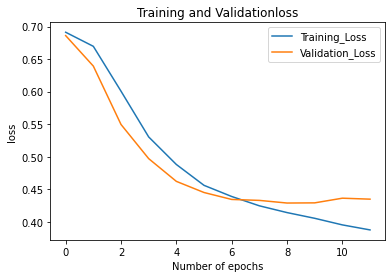

In [ ]:
plot_graphs1('Training_Loss','Validation_Loss','loss')

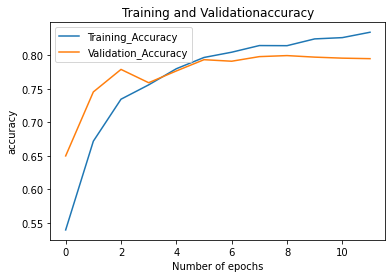

In [ ]:
plot_graphs1('Training_Accuracy','Validation_Accuracy','accuracy')

## Dense Network (Overfitting Model)

This model as shown below is most likely to be overfitting. The model as shown as 2 densely connected layers of 64 elements.

In the beginning, the validation loss decreases. However, at approximately epochs 4, validation loss does not continue to decrease but instead, it increases rapidly. This shows that this is where it begins to overfit. 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 75, 16)            208000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 64)                1088      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 213,313
Trainable params: 213,313
Non-trainable params: 0
________________________________________________

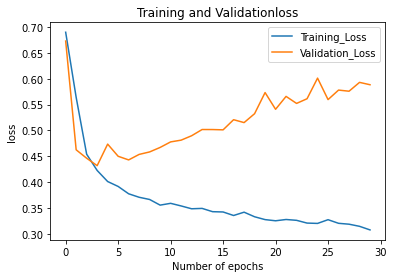

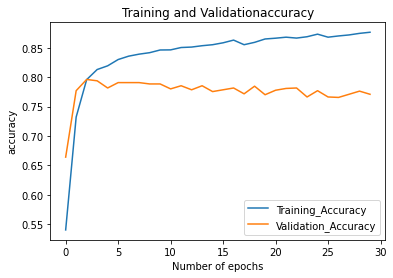

In [ ]:
vocab_size = 13000 #Defined earlier as number_of_tokens
embeding_dim = 16
drop_value = 0.2
n_dense = 24

overfitmodel = Sequential()
overfitmodel.add(Embedding(vocab_size,embeding_dim,input_length=max_len))
overfitmodel.add(GlobalAveragePooling1D())
overfitmodel.add(Dense(64,activation='relu'))
overfitmodel.add(Dense(64,activation='relu'))
overfitmodel.add(Dense(1,activation='sigmoid'))

overfitmodel.summary()

overfitmodel.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])

num_epochs = 30
history = overfitmodel.fit(training_padded, isDisaster_train, epochs=num_epochs, validation_data=(testing_padded, isDisaster_test),verbose=2)


loss, accuracy = overfitmodel.evaluate(testing_padded,isDisaster_test)
print('Accuracy:', round((accuracy*100),2),'%')
print('Loss:',round((loss*100),2),'%')

metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss':'Training_Loss','accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'},inplace=True)
def plot_graphs1(var1,var2,string):
  metrics[[var1,var2]].plot()
  plt.title('Training and Validation' + string)
  plt.xlabel('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1,var2])


plot_graphs1('Training_Loss','Validation_Loss','loss')
plot_graphs1('Training_Accuracy','Validation_Accuracy','accuracy')

From the training and validation accuracy graph, we can see that as the training accuracy continues to increase, the validation accuracy decreases slightly which increases the discrepancy between the training accuracy and validation accuracy. Therefore, showing that our data may have some extent of overfitting of data.

### Confusion matrices: Overfitted data

Confusion matrix will provide us with the details of the data's accuracy, precision, recall, F1 score and the false positive rate. 

[Text(452.23636363636354, 0.5, 'Actual'),
 Text(0.5, 15.0, 'Predicted\n\nAccuracy=0.77\nPrecision=0.82\nRecall=0.71\nFalse positive rate=0.16\nF1 Score=0.76'),
 Text(0.5, 1.0, 'Testing set')]

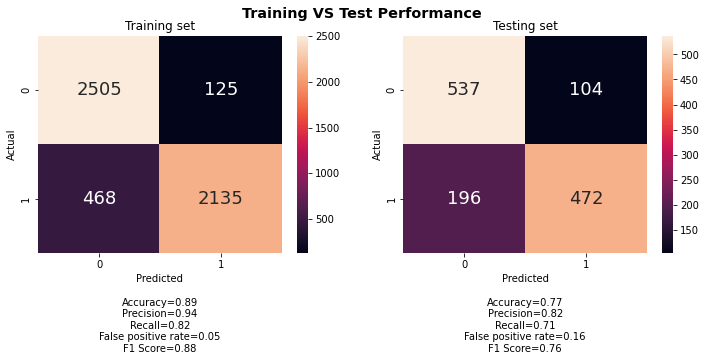

In [ ]:
# Visualise data
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import confusion_matrix
# Confusion matrix for train and test set

#Train prediction
train_predicted = (overfitmodel.predict(training_padded)>=0.5).astype('int64')

#Test prediction
test_predicted = (overfitmodel.predict(testing_padded)>=0.5).astype('int64')

#Plotting of confusion matrix 
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Training VS Test Performance',fontweight = 'bold', fontsize = 'x-large')

#Train confusion matrix 
sb.heatmap(confusion_matrix(isDisaster_train, train_predicted),
    annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])


sb.heatmap(confusion_matrix(isDisaster_test, test_predicted), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])



#Calculate metrix for train
CM_train= confusion_matrix(isDisaster_train,train_predicted)
TN = CM_train[0][0]
FN = CM_train[1][0]
TP = CM_train[1][1]
FP = CM_train[0][1]

Accuracy_train = (TP+TN)/(TP+FN+TN+FP)
Precision_train = TP/(TP+FP)
Recall_train = TP/(TP+FN)
FPR = FP/(TN+FP)
F1_score_train = 2*Precision_train*Recall_train/(Precision_train+Recall_train)

Train_stats = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nFalse positive rate={:0.2f}\nF1 Score={:0.2f}".format(
        Accuracy_train, Precision_train, Recall_train,FPR,F1_score_train)
axes[0].set(xlabel = 'Predicted' + Train_stats,ylabel='Actual',title = 'Training set')



#Calculate metrix for test
CM_train= confusion_matrix(isDisaster_test,test_predicted)
TN = CM_train[0][0]
FN = CM_train[1][0]
TP = CM_train[1][1]
FP = CM_train[0][1]

Accuracy_test = (TP+TN)/(TP+FN+TN+FP)
Precision_test = TP/(TP+FP)
Recall_test = TP/(TP+FN)
FPR = FP/(TN+FP)
F1_score_test = 2*Precision_test*Recall_test/(Precision_test+Recall_test)

Test_stats  = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nFalse positive rate={:0.2f}\nF1 Score={:0.2f}".format(
        Accuracy_test, Precision_test, Recall_test, FPR,F1_score_test)
axes[1].set(xlabel = 'Predicted'+Test_stats,ylabel='Actual',title = 'Testing set')

## Dense Network (After handling overfit data)
---

To handle overfitting of data, 


1.   Reduce the network's capacity where we remove layers and reduce the number of elements in the hidden layer as seen. 
2.   Included a dropout layer in order to prevent overfitting of data
3.   Include early stopping to stop the fitting of model after 2 continuous validation loss

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 75, 16)            208000    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 208,289
Trainable params: 208,289
Non-trainable params: 0
________________________________________________

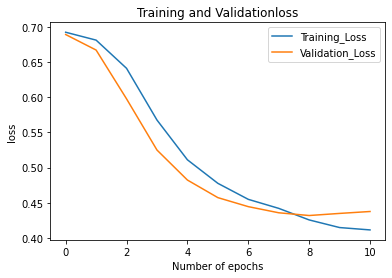

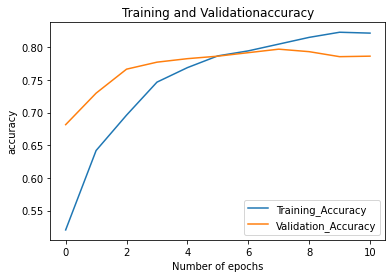

In [ ]:
vocab_size = 13000 #Defined earlier as number_of_tokens
embeding_dim = 16
drop_value = 0.2
n_dense = 24


model = Sequential()
model.add(Embedding(vocab_size,embeding_dim,input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1,activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss',patience=2)
history = model.fit(training_padded, isDisaster_train, epochs=num_epochs, validation_data=(testing_padded, isDisaster_test),callbacks=[early_stop],verbose=2)


loss, accuracy = model.evaluate(testing_padded,isDisaster_test)
print('Accuracy:', round((accuracy*100),2),'%')
print('Loss:',round((loss*100),2),'%')

metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss':'Training_Loss','accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'},inplace=True)
def plot_graphs1(var1,var2,string):
  metrics[[var1,var2]].plot()
  plt.title('Training and Validation' + string)
  plt.xlabel('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1,var2])


plot_graphs1('Training_Loss','Validation_Loss','loss')
plot_graphs1('Training_Accuracy','Validation_Accuracy','accuracy')

### Confusion matrices: After handling overfitted data

Confusion matrix will provide us with the details of the data's accuracy, precision, recall, F1 score and the false positive rate. 

[Text(452.23636363636354, 0.5, 'Actual'),
 Text(0.5, 15.0, 'Predicted\n\nAccuracy=0.79\nPrecision=0.77\nRecall=0.82\nFalse positive rate=0.25\nF1 Score=0.80'),
 Text(0.5, 1.0, 'Testing set')]

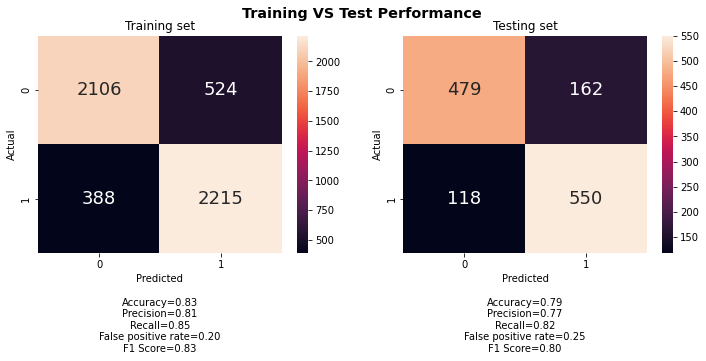

In [ ]:
# Visualise data
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import confusion_matrix
# Confusion matrix for train and test set

#Train prediction
train_predicted = (model.predict(training_padded)>=0.5).astype('int64')

#Test prediction
test_predicted = (model.predict(testing_padded)>=0.5).astype('int64')

#Plotting of confusion matrix 
f, axes = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Training VS Test Performance',fontweight = 'bold', fontsize = 'x-large')

#Train confusion matrix 
sb.heatmap(confusion_matrix(isDisaster_train, train_predicted),
    annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])


sb.heatmap(confusion_matrix(isDisaster_test, test_predicted), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])



#Calculate metrix for train
CM_train= confusion_matrix(isDisaster_train,train_predicted)
TN = CM_train[0][0]
FN = CM_train[1][0]
TP = CM_train[1][1]
FP = CM_train[0][1]

Accuracy_train = (TP+TN)/(TP+FN+TN+FP)
Precision_train = TP/(TP+FP)
Recall_train = TP/(TP+FN)
FPR = FP/(TN+FP)
F1_score_train = 2*Precision_train*Recall_train/(Precision_train+Recall_train)

Train_stats = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nFalse positive rate={:0.2f}\nF1 Score={:0.2f}".format(
        Accuracy_train, Precision_train, Recall_train,FPR,F1_score_train)
axes[0].set(xlabel = 'Predicted' + Train_stats,ylabel='Actual',title = 'Training set')



#Calculate metrix for test
CM_train= confusion_matrix(isDisaster_test,test_predicted)
TN = CM_train[0][0]
FN = CM_train[1][0]
TP = CM_train[1][1]
FP = CM_train[0][1]

Accuracy_test = (TP+TN)/(TP+FN+TN+FP)
Precision_test = TP/(TP+FP)
Recall_test = TP/(TP+FN)
FPR = FP/(TN+FP)
F1_score_test = 2*Precision_test*Recall_test/(Precision_test+Recall_test)

Test_stats  = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nFalse positive rate={:0.2f}\nF1 Score={:0.2f}".format(
        Accuracy_test, Precision_test, Recall_test, FPR,F1_score_test)
axes[1].set(xlabel = 'Predicted'+Test_stats,ylabel='Actual',title = 'Testing set')

After handling the overfitting of data, 


*   Accuracy have improved
*   Smaller discrepancy between the training and validation set





## Comparision of results (Dense Network)
---
The bar plot helps to compare between the accuracy of the data that were overfitted and the accurcay of the data after we had handled the overfitting of data.

Clearly, after handling the overfitting of our data, it have help to increase the accuracy of our data.

41/41 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7861


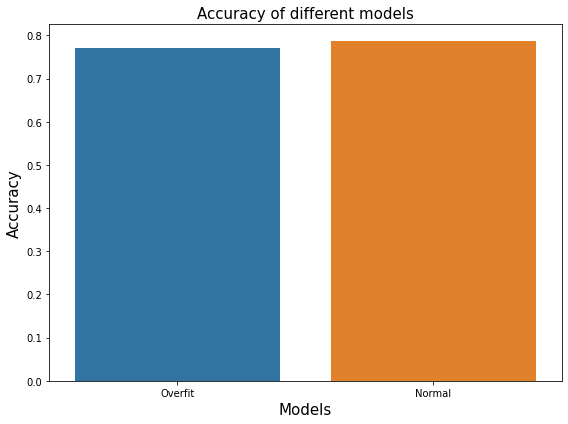

In [ ]:
# Visualise data before and after we fix overfitting data in terms of accuracy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as isDisaster_tweets_numpy
import seaborn as sns

overfitDense_loss,overfitDense_accuracy = overfitmodel.evaluate(testing_padded,isDisaster_test)
Dense_loss,Dense_accuracy = model.evaluate(testing_padded,isDisaster_test)


models = ['Overfit','Normal']
accuracy = [overfitDense_accuracy,Dense_accuracy]

df = pd.DataFrame({"Models":models,"Accuracy":accuracy})
df

plt.figure(figsize=(8,6))
sns.barplot(x='Models',y="Accuracy",data=df,order=df.sort_values('Accuracy').Models)
plt.xlabel("Models",size = 15)
plt.ylabel("Accuracy",size = 15)
plt.title("Accuracy of different models",size = 15)
plt.tight_layout()

## LSTM Model
---
Long short term memory networks are a special kind of RNN that are capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavour. 


In [ ]:
n_lstm = 20
drop_lstm = 0.2

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length = max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss',patience=2)
history = model1.fit(training_padded,isDisaster_train,epochs=num_epochs,validation_data=(testing_padded,isDisaster_test),callbacks=[early_stop],verbose=2)


Epoch 1/30
164/164 - 8s - loss: 0.6726 - accuracy: 0.5735 - val_loss: 0.6339 - val_accuracy: 0.6382 - 8s/epoch - 49ms/step
Epoch 2/30
164/164 - 5s - loss: 0.5753 - accuracy: 0.7063 - val_loss: 0.5695 - val_accuracy: 0.7518 - 5s/epoch - 31ms/step
Epoch 3/30
164/164 - 5s - loss: 0.5283 - accuracy: 0.7605 - val_loss: 0.5108 - val_accuracy: 0.7624 - 5s/epoch - 31ms/step
Epoch 4/30
164/164 - 5s - loss: 0.4846 - accuracy: 0.7890 - val_loss: 0.4957 - val_accuracy: 0.7725 - 5s/epoch - 32ms/step
Epoch 5/30
164/164 - 5s - loss: 0.4630 - accuracy: 0.8018 - val_loss: 0.4988 - val_accuracy: 0.7649 - 5s/epoch - 31ms/step
Epoch 6/30
164/164 - 6s - loss: 0.4401 - accuracy: 0.8128 - val_loss: 0.4807 - val_accuracy: 0.7826 - 6s/epoch - 34ms/step
Epoch 7/30
164/164 - 10s - loss: 0.4313 - accuracy: 0.8177 - val_loss: 0.4894 - val_accuracy: 0.7824 - 10s/epoch - 64ms/step
Epoch 8/30
164/164 - 7s - loss: 0.4135 - accuracy: 0.8258 - val_loss: 0.4715 - val_accuracy: 0.7810 - 7s/epoch - 42ms/step
Epoch 9/30
164

In [ ]:
model1.evaluate(testing_padded,isDisaster_test)

41/41 [==============================] - 0s 7ms/step - loss: 0.5056 - accuracy: 0.7751


[0.505580723285675, 0.7750954627990723]

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

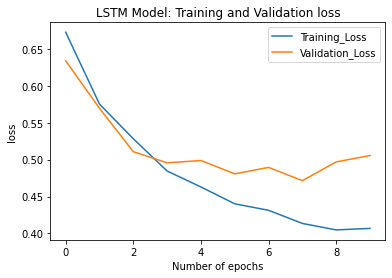

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

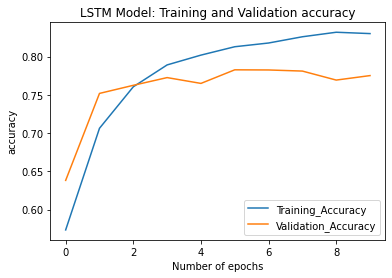

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Bi-directional LSTM
---
Lastly, we carried out bi-directional long short term memory to train our model. Bidirectional long short term memory is the process of making any neural network have the sequence information in both direction. The input would flow in two directions which caused it to differ from the long-short term memory that we used before. 

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, isDisaster_train, epochs=num_epochs, 
                    validation_data=(testing_padded, isDisaster_test),callbacks =[early_stop], verbose=2)

Epoch 1/30
164/164 - 13s - loss: 0.6910 - accuracy: 0.5359 - val_loss: 0.6491 - val_accuracy: 0.6893 - 13s/epoch - 79ms/step
Epoch 2/30
164/164 - 7s - loss: 0.5590 - accuracy: 0.7289 - val_loss: 0.5586 - val_accuracy: 0.7082 - 7s/epoch - 45ms/step
Epoch 3/30
164/164 - 8s - loss: 0.5104 - accuracy: 0.7701 - val_loss: 0.5218 - val_accuracy: 0.7697 - 8s/epoch - 50ms/step
Epoch 4/30
164/164 - 7s - loss: 0.4866 - accuracy: 0.7898 - val_loss: 0.4970 - val_accuracy: 0.7821 - 7s/epoch - 45ms/step
Epoch 5/30
164/164 - 7s - loss: 0.4654 - accuracy: 0.8020 - val_loss: 0.4884 - val_accuracy: 0.7814 - 7s/epoch - 45ms/step
Epoch 6/30
164/164 - 7s - loss: 0.4593 - accuracy: 0.8051 - val_loss: 0.4931 - val_accuracy: 0.7767 - 7s/epoch - 45ms/step
Epoch 7/30
164/164 - 7s - loss: 0.5023 - accuracy: 0.7625 - val_loss: 0.5378 - val_accuracy: 0.7122 - 7s/epoch - 45ms/step


In [ ]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

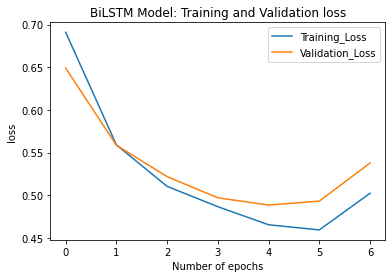

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

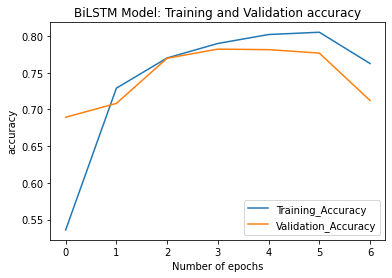

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Comparing three different models 

In [ ]:
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded,isDisaster_test)}")
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded,isDisaster_test)}")
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded,isDisaster_test)}")

41/41 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7861
Dense architecture loss and accuracy: [0.4375218152999878, 0.7860962748527527]
41/41 [==============================] - 0s 8ms/step - loss: 0.5056 - accuracy: 0.7751
LSTM architecture loss and accuracy: [0.505580723285675, 0.7750954627990723]
41/41 [==============================] - 0s 11ms/step - loss: 0.5378 - accuracy: 0.7122
Bi-LSTM architecture loss and accuracy: [0.5377853512763977, 0.7121873497962952]


We uses a bar plot to help with the visualisation of our results. Hence, by sorting the data to be shown in an ascending order in the bar plot, our results show that out of the three models, the dense model have provided us with the best accuracy result. 

However, we also note that this three models may not provide us with a high accuracy of 90%, hence, in the future, we can try out other natural language process model such as the BERT model. 

41/41 [==============================] - 0s 11ms/step - loss: 0.5378 - accuracy: 0.7122


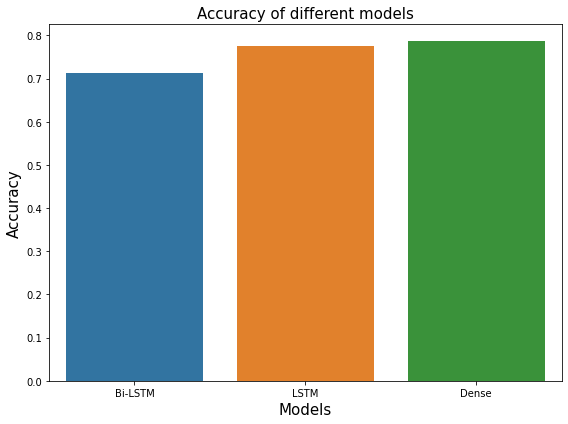

In [ ]:
# Visualisation to compare the different 3 models in terms of their accuracy 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as isDisaster_tweets_numpy
import seaborn as sns

Dense_loss,Dense_accuracy = model.evaluate(testing_padded,isDisaster_test)
LSTM_loss,LSTM_accuracy = model1.evaluate(testing_padded,isDisaster_test)
BiLSTM_loss,BiLSTM_accuracy = model2.evaluate(testing_padded,isDisaster_test)

models = ['Dense','LSTM','Bi-LSTM']
accuracy = [Dense_accuracy,LSTM_accuracy,BiLSTM_accuracy]

df = pd.DataFrame({"Models":models,"Accuracy":accuracy})
df

plt.figure(figsize=(8,6))
sns.barplot(x='Models',y="Accuracy",data=df,order=df.sort_values('Accuracy').Models)
plt.xlabel("Models",size = 15)
plt.ylabel("Accuracy",size = 15)
plt.title("Accuracy of different models",size = 15)
plt.tight_layout()


## Other methods: Decision Tree Classifier
---
Decision Tree is a supervised machine learning algorithm, that is similar to how humans make decisions. 

Here, we used the decision tree to obtain results for classification. The intuiton behind it is that we train our data to predict their outputs. 

Here, we create a decision tree of max_depth 4 and obtain our results as shown by the confusion metrics.



Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6128415822663864

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5828877005347594



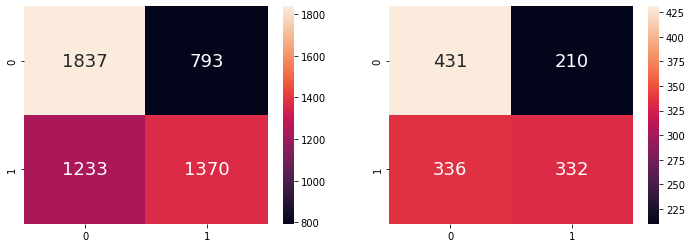

In [ ]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(training_padded, isDisaster_train)   # train the decision tree model

# Predict 
y_train_pred = dectree.predict(training_padded)
y_test_pred = dectree.predict(testing_padded)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(training_padded, isDisaster_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(testing_padded,isDisaster_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(isDisaster_train, y_train_pred),
    annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(isDisaster_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

However, as seen from the classification accuracy, the accuracy of the test dataset is approximately 59%. Hence, suggessting that it might not be a good representation of our dataset. 

## Other methods : Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, classification_report
from sklearn.metrics import plot_confusion_matrix

In [ ]:
forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 2)
modelF = forest.fit(training_padded,isDisaster_train)
y_predF = modelF.predict(testing_padded)

In [ ]:
acc_score = accuracy_score(isDisaster_test,y_predF)
pre_score = precision_score(isDisaster_test,y_predF)
rec_score = recall_score(isDisaster_test,y_predF)

In [ ]:
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)

Accuracy_score:  0.6203208556149733
Precision_score:  0.6586270871985158
Recall_score:  0.531437125748503


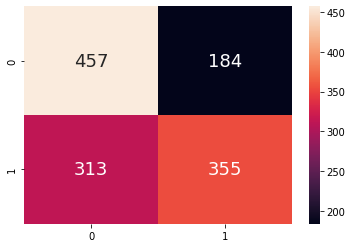

In [ ]:
sb.heatmap(confusion_matrix(isDisaster_test,y_predF),annot = True, fmt=".0f", annot_kws={"size": 18})

By using the default hyperparameters of random forest tree, we found that it would not provide us with a high accuracy. 

Hence, as we try to pass this as a parameter to GridSearchCV to train our random forest classifier model using all possible combinations of these parameters to find the best model. However, due to time constraint and inability to understand the GridSearchCV, we were unable to improve our accuracy score using the GridSearchCV parameters. In the future, we would try to tune the hyperparameters better in order for us to improve our accuracy using the Random Forest tree. 

Tune the hyperparameter using GridSearchCV from sklearn

GridSearchCV will take the following parameters:


*   Estimator - RandomForestClassifier
*   Parameters 
*   CV - signifies cross-validation folds
*   return_train_score - returns the training scores of the various models
*   n_jobs - no. of jobs to run parallely



In [ ]:
parameters = {'max_features':('auto','sqrt'),
              'n_estimators':[10],
              'max_depth':[None],
              'min_samples_split':[5,10,15],
              'min_samples_leaf':[1,2,5,10],
              'bootstrap':[True,False]}

## Validation
---

Using another dataset, we can check the accuracy of our model. 

In [ ]:
validationDataURL = "https://raw.githubusercontent.com/woonyee28/mini-project/main/data/validation_data.csv" #Assign link of dataset to variable
validation_tweets = pd.read_csv(validationDataURL)
validation_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la rong ask canada,1
2,5,NaN,NaN,reside ask shelter place notify offic evac she...,1
3,6,NaN,NaN,peopl receiv wildfire evac order california,1
4,7,NaN,NaN,got sent photo rub alaska smoke wildfire pour ...,1


In [ ]:
validation_tweets.rename(columns={'target': 'isDisaster'},inplace=True) #Rename the column 'label' to 'isDisaster'
validation_tweets.groupby('isDisaster').count() #Group based on the category, and count the number of entries for each category

,id,keyword,location,text
isDisaster,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


In [ ]:
remove_all(validation_tweets, 'text'); #removes all unnecessary characters from [dataset, column]
validation_tweets.drop(['keyword', 'location'], axis=1, inplace=True) #Removes unnecessary rows from the dataset
validation_tweets.head(100) #Verify that all unnecessary characters have been removed from the dataset

,id,text,isDisaster
0,1,deed reason earthquake may allah forgive us,1
1,4,forest fire near la rong ask canada,1
2,5,reside ask shelter place notify offic evac she...,1
3,6,peopl receiv wildfire evac order california,1
4,7,got sent photo rub alaska smoke wildfire pour ...,1
...,...,...,...
95,137,mile backup south acid block right lane exit s...,1
96,138,acid chang life help determin option finance s...,0
97,139,break dead motorcycle car acid happen hagersto...,1
98,141,floor marina acid,0


In [ ]:
tweets_validation, isDisaster_validation = validation_tweets['text'], validation_tweets['isDisaster']

In [ ]:
isDisaster_validation.head()

0    1
1    1
2    1
3    1
4    1
Name: isDisaster, dtype: int64

In [ ]:
max_len = 75 
trunc_type = "post" 
padding_type = "post" 
oov_token = "<OOV>" 
number_of_tokens = 1000

tokenizer = Tokenizer(num_words = number_of_tokens, lower= 1, oov_token= oov_token) #Initializing Tokenizer
tokenizer.fit_on_texts(tweets_validation) #Process of transforming words into numbers into a dictionary
word_index = tokenizer.word_index

validation_sequences = tokenizer.texts_to_sequences(tweets_validation)

validation_padded = pad_sequences (validation_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

In [ ]:
#accuracy for first model (double confirming)
validation_tweets['first_model_ans'] = pd.DataFrame(np.around(model.predict(validation_padded),decimals=0))
validation_tweets['first_model_acc'] = np.where(validation_tweets['first_model_ans'] == validation_tweets['isDisaster'], 'True', 'False')
count = 0
for i in validation_tweets['first_model_acc']:
  if i=='True':
    count+=1
count/len(validation_tweets['first_model_acc'])

0.49402338105871535

In [ ]:
print(f"Dense architecture loss and accuracy: {model.evaluate(validation_padded,isDisaster_validation)}")
print(f"LSTM architecture loss and accuracy: {model1.evaluate(validation_padded,isDisaster_validation)}")
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(validation_padded,isDisaster_validation)}")

238/238 [==============================] - 0s 1ms/step - loss: 0.9084 - accuracy: 0.4940
Dense architecture loss and accuracy: [0.9083773493766785, 0.4940233826637268]
238/238 [==============================] - 2s 8ms/step - loss: 1.1536 - accuracy: 0.5361
LSTM architecture loss and accuracy: [1.1535794734954834, 0.5360830426216125]
238/238 [==============================] - 3s 11ms/step - loss: 0.7958 - accuracy: 0.5761
Bi-LSTM architecture loss and accuracy: [0.795810341835022, 0.5760917663574219]


As seen from the results, the accuracy using dense network is approximately 49%, while for the LSTM model, it is 53% and lastly for the Bi-LSTM model, it is 57%. 

In this case, the Bi-LSTM architecture had provided a better accuracy. 

However, as our accuracy is only approximately 50%, it shows that while the accuracy is not perfect/good, our test dataset have learn some universal features. 

The decrease in our accuracy of ur results may be due to the difference in the dataset. Furthermore, this may also suggests that our data sample may be unrepresntative which may not have a broad domain. 